# Electrophysiology Pipeline with Object Storage

This tutorial builds an electrophysiology analysis pipeline using DataJoint with the `<npy@>` codec for efficient array storage. You'll learn to:

- **Configure** object storage for neural data
- **Import** neural recordings using `<npy@>` (lazy loading)
- **Compute** activity statistics
- **Detect spikes** using parameterized thresholds
- **Extract waveforms** as stacked arrays
- **Use memory mapping** for efficient random access
- **Access files directly** without database queries

## The Pipeline

<img src="/images/ephys-npy-pipeline.svg" alt="Electrophysiology Pipeline" width="600">

**Legend:** Green = Manual, Gray = Lookup, Blue = Imported, Red = Computed

Each session records from neurons. We compute statistics, detect spikes with configurable thresholds, and extract spike waveforms.

## Why `<npy@>` Instead of `<blob@>`?

| Feature | `<npy@>` | `<blob@>` |
|---------|----------|-----------|
| **Lazy loading** | Yes - inspect shape/dtype without download | No - always downloads |
| **Memory mapping** | Yes - random access via `mmap_mode` | No |
| **Format** | Portable `.npy` files | DataJoint serialization |
| **Bulk fetch** | Safe - returns references | Downloads everything |
| **Direct access** | Yes - navigable file paths | No - hash-addressed |

## Setup

First, configure object storage for the `<npy@>` codec.

In [1]:
import datajoint as dj

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile

# Create a temporary directory for object storage
STORE_PATH = tempfile.mkdtemp(prefix='dj_ephys_')

# Configure object storage with partitioning by mouse_id, session_date, and neuron_id
dj.config.stores['ephys'] = {
    'protocol': 'file',
    'location': STORE_PATH,
    'partition_pattern': '{mouse_id}/{session_date}/{neuron_id}',  # Partition by subject, session, and neuron
}

schema = dj.Schema('tutorial_electrophysiology_npy')

# Data directory (relative to this notebook)
DATA_DIR = Path('./data')

print(f"Store configured at: {STORE_PATH}")
print("Partitioning: {mouse_id}/{session_date}/{neuron_id}")

[2026-01-22 22:54:32,951][INFO]: DataJoint 2.1.0a5 connected to postgres@localhost:5432


Store configured at: /var/folders/cn/dpwf5t7j3gd8gzyw2r7dhm8r0000gn/T/dj_ephys_zv4xfv96
Partitioning: {mouse_id}/{session_date}/{neuron_id}


### Partitioning by Subject, Session, and Neuron

We've configured the store with `partition_pattern: '{mouse_id}/{session_date}/{neuron_id}'`. This organizes storage by the complete experimental hierarchy—grouping all data for each individual neuron together at the top of the directory structure.

**Without partitioning:**
```
{store}/{schema}/{table}/{mouse_id=X}/{session_date=Y}/{neuron_id=Z}/file.npy
```

**With partitioning:**
```
{store}/{mouse_id=X}/{session_date=Y}/{neuron_id=Z}/{schema}/{table}/file.npy
```

Partitioning moves the specified primary key attributes to the front of the path, making it easy to:
- **Browse by experimental hierarchy** - Navigate: subject → session → neuron
- **Selective sync** - Copy all data for one neuron: `rsync mouse_id=100/session_date=2017-05-25/neuron_id=0/ backup/`
- **Efficient queries** - Filesystem can quickly locate specific neurons
- **Publication-ready** - Export complete hierarchies to data repositories

The remaining primary key attributes (like `spike_param_id` in the Spikes table) stay in their normal position after the schema/table path.

## Manual Tables: Experiment Metadata

In [2]:
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int32
    ---
    dob : date
    sex : enum('M', 'F', 'unknown')
    """


@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_date : date
    ---
    experimenter : varchar(100)
    """

### Insert Sample Data

Our data files follow the naming convention `data_{mouse_id}_{session_date}.npy`.

In [3]:
# Insert mice
Mouse.insert([
    {'mouse_id': 0, 'dob': '2017-03-01', 'sex': 'M'},
    {'mouse_id': 5, 'dob': '2016-12-25', 'sex': 'F'},
    {'mouse_id': 100, 'dob': '2017-05-12', 'sex': 'F'},
], skip_duplicates=True)

# Insert sessions (matching our data files)
Session.insert([
    {'mouse_id': 0, 'session_date': '2017-05-15', 'experimenter': 'Alice'},
    {'mouse_id': 0, 'session_date': '2017-05-19', 'experimenter': 'Alice'},
    {'mouse_id': 5, 'session_date': '2017-01-05', 'experimenter': 'Bob'},
    {'mouse_id': 100, 'session_date': '2017-05-25', 'experimenter': 'Carol'},
    {'mouse_id': 100, 'session_date': '2017-06-01', 'experimenter': 'Carol'},
], skip_duplicates=True)

Session()

mouse_id None,session_date,experimenter
0,2017-05-15,Alice
0,2017-05-19,Alice
5,2017-01-05,Bob
100,2017-05-25,Carol
100,2017-06-01,Carol


## Imported Table: Neuron Activity with `<npy@>`

Each data file contains recordings from one or more neurons. We import each neuron's activity trace using `<npy@ephys>` for schema-addressed object storage.

In [4]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id : int16
    ---
    activity : <npy@ephys>    # neural activity trace (lazy loading)
    """

    def make(self, key):
        # Construct filename from key
        filename = f"data_{key['mouse_id']}_{key['session_date']}.npy"
        filepath = DATA_DIR / filename
        
        # Load data (shape: n_neurons x n_timepoints)
        data = np.load(filepath)
        
        # Insert one row per neuron
        for neuron_id, activity in enumerate(data):
            self.insert1({
                **key,
                'neuron_id': neuron_id,
                'activity': activity
            })
        
        print(f"Imported {len(data)} neuron(s) from {filename}")

In [5]:
Neuron.populate(display_progress=True)

Neuron:   0%|          | 0/5 [00:00<?, ?it/s]

Neuron: 100%|██████████| 5/5 [00:00<00:00, 337.56it/s]

Imported 1 neuron(s) from data_0_2017-05-15.npy
Imported 1 neuron(s) from data_0_2017-05-19.npy
Imported 1 neuron(s) from data_5_2017-01-05.npy
Imported 1 neuron(s) from data_100_2017-05-25.npy
Imported 1 neuron(s) from data_100_2017-06-01.npy


{'success_count': 5, 'error_list': []}

In [6]:
Neuron()

mouse_id None,session_date None,neuron_id,activity neural activity trace (lazy loading)
0,2017-05-15,0,<npy>
0,2017-05-19,0,<npy>
5,2017-01-05,0,<npy>
100,2017-05-25,0,<npy>
100,2017-06-01,0,<npy>


### Lazy Loading with NpyRef

When fetching `<npy@>` attributes, you get an `NpyRef` that provides metadata without downloading the array.

In [7]:
# Fetch returns NpyRef, not the array
key = {'mouse_id': 0, 'session_date': '2017-05-15', 'neuron_id': 0}
ref = (Neuron & key).fetch1('activity')

print(f"Type: {type(ref).__name__}")
print(f"Shape: {ref.shape} (no download!)")
print(f"Dtype: {ref.dtype}")
print(f"Is loaded: {ref.is_loaded}")

Type: NpyRef
Shape: (1000,) (no download!)
Dtype: float64
Is loaded: False


In [8]:
# Explicitly load when ready
activity = ref.load()
print(f"Loaded: {activity.shape}, is_loaded: {ref.is_loaded}")

Loaded: (1000,), is_loaded: True


### Memory Mapping for Large Arrays

For very large arrays, use `mmap_mode` to access data without loading it all into memory. This is especially efficient for local filesystem stores.

In [9]:
# Memory-mapped loading - efficient for large arrays
key = {'mouse_id': 0, 'session_date': '2017-05-15', 'neuron_id': 0}
ref = (Neuron & key).fetch1('activity')

# Load as memory-mapped array (read-only)
mmap_arr = ref.load(mmap_mode='r')

print(f"Type: {type(mmap_arr).__name__}")
print(f"Shape: {mmap_arr.shape}")

# Random access only reads the needed portion from disk
slice_data = mmap_arr[100:200]
print(f"Slice [100:200]: {slice_data[:5]}...")

Type: memmap
Shape: (1000,)
Slice [100:200]: [-0.09536487  0.00759549 -0.14405436 -0.08785159 -0.14242823]...


### Visualize Neural Activity

NpyRef works transparently with NumPy functions via `__array__`.

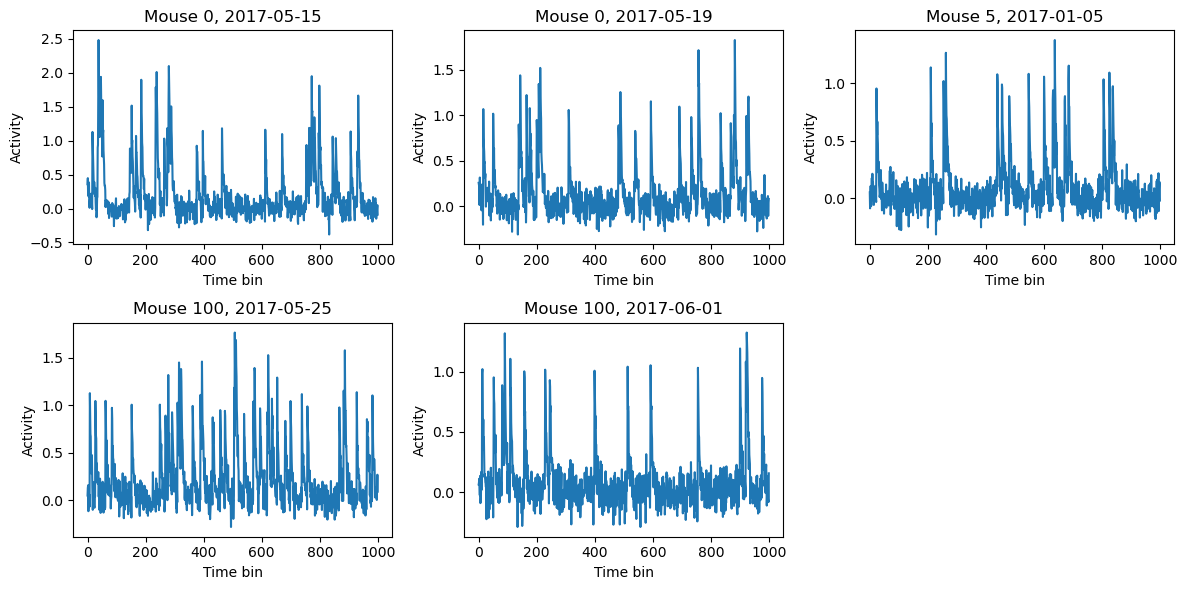

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ax, key in zip(axes.ravel(), Neuron.keys()):
    # fetch1 returns NpyRef, but plotting works via __array__
    activity = (Neuron & key).fetch1('activity')
    ax.plot(np.asarray(activity))  # Convert to array for plotting
    ax.set_title(f"Mouse {key['mouse_id']}, {key['session_date']}")
    ax.set_xlabel('Time bin')
    ax.set_ylabel('Activity')

# Hide unused subplot
axes[1, 2].axis('off')
plt.tight_layout()

## Computed Table: Activity Statistics

For each neuron, compute basic statistics of the activity trace. NumPy functions work directly with NpyRef.

In [11]:
@schema
class ActivityStats(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean_activity : float32
    std_activity : float32
    max_activity : float32
    """

    def make(self, key):
        # fetch1 returns NpyRef, but np.mean/std/max work via __array__
        activity = (Neuron & key).fetch1('activity')
        
        self.insert1({
            **key,
            'mean_activity': np.mean(activity),  # Auto-loads via __array__
            'std_activity': np.std(activity),
            'max_activity': np.max(activity)
        })

In [12]:
ActivityStats.populate(display_progress=True)
ActivityStats()

ActivityStats:   0%|          | 0/5 [00:00<?, ?it/s]

ActivityStats: 100%|██████████| 5/5 [00:00<00:00, 457.70it/s]

mouse_id None,session_date None,neuron_id None,mean_activity,std_activity,max_activity
0,2017-05-15,0,0.20735653,0.40086678,2.481606
0,2017-05-19,0,0.1327401,0.2914616,1.8280541
5,2017-01-05,0,0.089178555,0.23641196,1.3738891
100,2017-05-25,0,0.21906962,0.32878324,1.7638324
100,2017-06-01,0,0.08732656,0.23785825,1.324542


## Lookup Table: Spike Detection Parameters

Spike detection depends on threshold choice. Using a Lookup table, we can run detection with multiple thresholds and compare results.

In [13]:
@schema
class SpikeParams(dj.Lookup):
    definition = """
    spike_param_id : int16
    ---
    threshold : float32    # spike detection threshold
    """
    
    contents = [
        {'spike_param_id': 1, 'threshold': 0.5},
        {'spike_param_id': 2, 'threshold': 0.9},
    ]

SpikeParams()

spike_param_id,threshold spike detection threshold
1,0.5
2,0.9


## Computed Table: Spike Detection

Detect spikes by finding threshold crossings. Store spike times and all waveforms as `<npy@>` arrays.

In [14]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeParams
    ---
    spike_times : <npy@ephys>    # indices of detected spikes
    spike_count : int64         # total number of spikes
    waveforms : <npy@ephys>      # all waveforms stacked (n_spikes x window_size)
    """

    def make(self, key):
        # Fetch inputs - activity is NpyRef
        activity_ref = (Neuron & key).fetch1('activity')
        threshold = (SpikeParams & key).fetch1('threshold')
        
        # Load activity for processing
        activity = activity_ref.load()
        
        # Detect threshold crossings (rising edge)
        above_threshold = (activity > threshold).astype(int)
        rising_edge = np.diff(above_threshold) > 0
        spike_times = np.where(rising_edge)[0] + 1  # +1 to get crossing point
        
        # Extract waveforms for all spikes
        window = 40  # samples before and after spike
        waveforms = []
        for t in spike_times:
            # Skip spikes too close to edges
            if t < window or t >= len(activity) - window:
                continue
            waveforms.append(activity[t - window : t + window])
        
        # Stack into 2D array (n_spikes x window_size)
        waveforms = np.vstack(waveforms) if waveforms else np.empty((0, 2 * window))
        
        # Insert entry with all data
        self.insert1({
            **key,
            'spike_times': spike_times,
            'spike_count': len(spike_times),
            'waveforms': waveforms,  # All waveforms as single array
        })

In [15]:
Spikes.populate(display_progress=True)

Spikes:   0%|          | 0/10 [00:00<?, ?it/s]

Spikes: 100%|██████████| 10/10 [00:00<00:00, 326.66it/s]

{'success_count': 10, 'error_list': []}

In [16]:
# View spike counts for each neuron x parameter combination
Spikes.proj('spike_count')

mouse_id None,session_date None,neuron_id None,spike_param_id None,spike_times indices of detected spikes,spike_count total number of spikes,waveforms all waveforms stacked (n_spikes x window_size)
0,2017-05-15,0,1,<npy>,26,<npy>
0,2017-05-15,0,2,<npy>,27,<npy>
0,2017-05-19,0,1,<npy>,24,<npy>
0,2017-05-19,0,2,<npy>,21,<npy>
5,2017-01-05,0,1,<npy>,18,<npy>
5,2017-01-05,0,2,<npy>,14,<npy>
100,2017-05-25,0,1,<npy>,41,<npy>
100,2017-05-25,0,2,<npy>,35,<npy>
100,2017-06-01,0,1,<npy>,18,<npy>
100,2017-06-01,0,2,<npy>,15,<npy>


### Compare Detection Thresholds

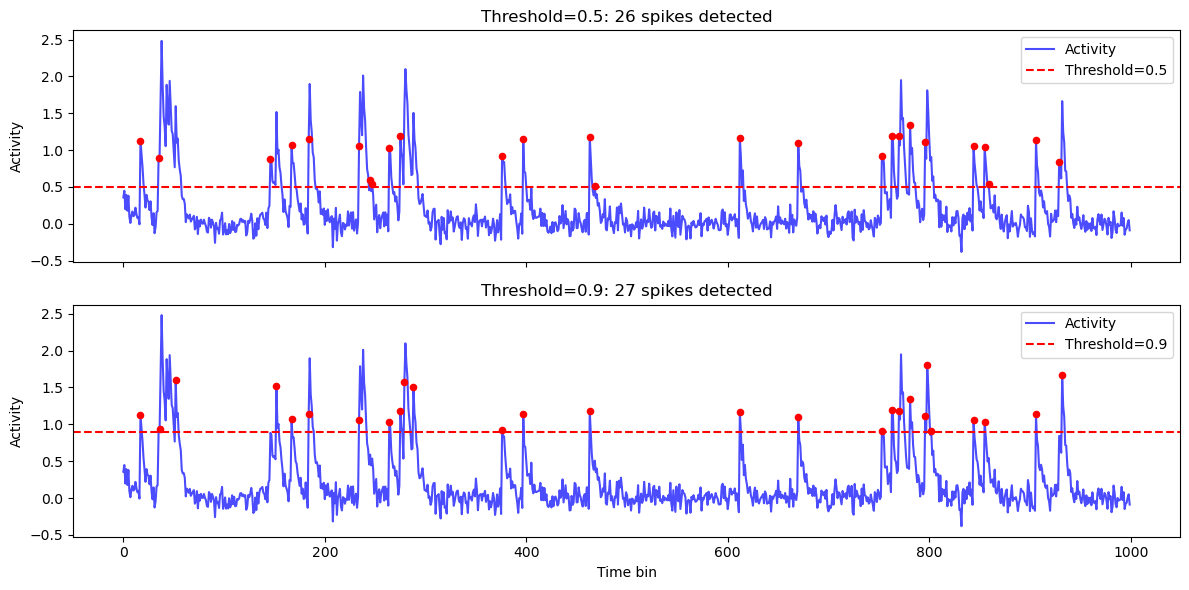

In [17]:
# Pick one neuron to visualize
neuron_key = {'mouse_id': 0, 'session_date': '2017-05-15', 'neuron_id': 0}
activity = (Neuron & neuron_key).fetch1('activity').load()  # Explicit load

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for ax, param_id in zip(axes, [1, 2]):
    key = {**neuron_key, 'spike_param_id': param_id}
    spike_times_ref = (Spikes & key).fetch1('spike_times')
    spike_times = spike_times_ref.load()  # Load spike times
    spike_count = (Spikes & key).fetch1('spike_count')
    threshold = (SpikeParams & {'spike_param_id': param_id}).fetch1('threshold')
    
    ax.plot(activity, 'b-', alpha=0.7, label='Activity')
    ax.axhline(threshold, color='r', linestyle='--', label=f'Threshold={threshold}')
    ax.scatter(spike_times, activity[spike_times], color='red', s=20, zorder=5)
    ax.set_title(f'Threshold={threshold}: {spike_count} spikes detected')
    ax.set_ylabel('Activity')
    ax.legend(loc='upper right')

axes[1].set_xlabel('Time bin')
plt.tight_layout()

### Average Waveform

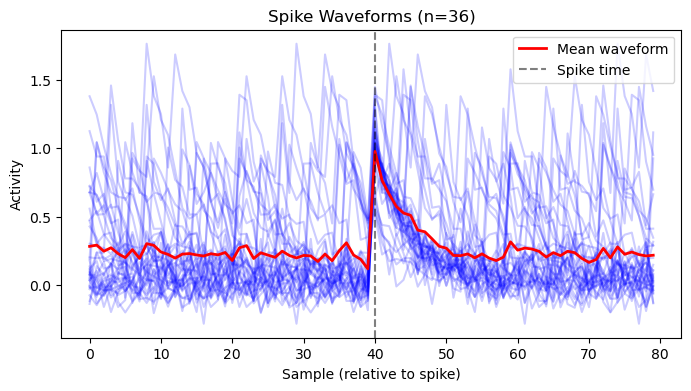

In [18]:
# Get waveforms for one neuron with threshold=0.5
key = {'mouse_id': 100, 'session_date': '2017-05-25', 'neuron_id': 0, 'spike_param_id': 1}

# Fetch waveforms NpyRef directly from Spikes table
waveforms_ref = (Spikes & key).fetch1('waveforms')

# Load the waveform matrix
waveform_matrix = waveforms_ref.load()

if len(waveform_matrix) > 0:
    plt.figure(figsize=(8, 4))
    # Plot individual waveforms (light)
    for wf in waveform_matrix:
        plt.plot(wf, 'b-', alpha=0.2)
    # Plot mean waveform (bold)
    plt.plot(waveform_matrix.mean(axis=0), 'r-', linewidth=2, label='Mean waveform')
    plt.axvline(40, color='k', linestyle='--', alpha=0.5, label='Spike time')
    plt.xlabel('Sample (relative to spike)')
    plt.ylabel('Activity')
    plt.title(f'Spike Waveforms (n={len(waveform_matrix)})')
    plt.legend()
else:
    print("No waveforms found for this key")

### Bulk Fetch with Lazy Loading

Fetching many rows returns NpyRefs - inspect metadata before downloading.

In [19]:
# Fetch all neurons - returns NpyRefs, NOT arrays
all_neurons = Neuron.to_dicts()
print(f"Fetched {len(all_neurons)} neurons\n")

# Inspect metadata without downloading
for neuron in all_neurons:
    ref = neuron['activity']
    print(f"Mouse {neuron['mouse_id']}, {neuron['session_date']}: "
          f"shape={ref.shape}, loaded={ref.is_loaded}")

Fetched 5 neurons

Mouse 0, 2017-05-15: shape=(1000,), loaded=False
Mouse 0, 2017-05-19: shape=(1000,), loaded=False
Mouse 5, 2017-01-05: shape=(1000,), loaded=False
Mouse 100, 2017-05-25: shape=(1000,), loaded=False
Mouse 100, 2017-06-01: shape=(1000,), loaded=False


## Pipeline Diagram

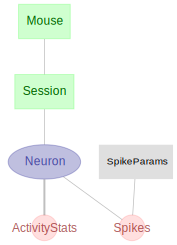

In [20]:
dj.Diagram(schema)

## Querying Results

DataJoint makes it easy to query across the pipeline.

In [21]:
# Find neurons with high spike counts (threshold=0.5)
(Spikes & 'spike_param_id = 1' & 'spike_count > 20').proj('spike_count')

mouse_id None,session_date None,neuron_id None,spike_param_id None,spike_times indices of detected spikes,spike_count total number of spikes,waveforms all waveforms stacked (n_spikes x window_size)
0,2017-05-15,0,1,<npy>,26,<npy>
0,2017-05-19,0,1,<npy>,24,<npy>
100,2017-05-25,0,1,<npy>,41,<npy>


In [22]:
# Join with Mouse to see which mice have most spikes
(Mouse * Session * Spikes & 'spike_param_id = 1').proj('spike_count')

mouse_id None,session_date None,neuron_id None,spike_param_id None,spike_count total number of spikes
0,2017-05-15,0,1,26
0,2017-05-19,0,1,24
5,2017-01-05,0,1,18
100,2017-05-25,0,1,41
100,2017-06-01,0,1,18


## Summary

This pipeline demonstrates key patterns for electrophysiology analysis with object storage:

| Concept | Example | Purpose |
|---------|---------|--------|
| **Object storage** | `<npy@ephys>` | Store arrays in file/S3/MinIO |
| **Lazy loading** | `NpyRef` | Inspect shape/dtype without download |
| **Memory mapping** | `ref.load(mmap_mode='r')` | Random access to large arrays |
| **Imported tables** | `Neuron` | Load data from files |
| **Computed tables** | `ActivityStats`, `Spikes` | Derive results |
| **Lookup tables** | `SpikeParams` | Parameterize analysis |
| **Array attributes** | `waveforms` | Store multi-spike data as single array |

### Key Benefits of `<npy@>`

1. **Lazy loading**: Inspect array metadata without downloading
2. **Memory mapping**: Random access to large arrays via `mmap_mode`
3. **Safe bulk fetch**: Fetching 1000 rows doesn't download 1000 arrays
4. **NumPy integration**: `np.mean(ref)` auto-downloads via `__array__`
5. **Portable format**: `.npy` files readable by NumPy, MATLAB, etc.
6. **Schema-addressed**: Files organized by schema/table/key
7. **Direct access**: Navigate and load files without database queries

## Direct File Access: Navigating the Store

A key advantage of `<npy@>` is **schema-addressed storage**: files are organized in a predictable directory structure that mirrors your database schema. This means you can navigate and access data files directly—without querying the database.

### Store Directory Structure with Partitioning

This tutorial uses `partition_pattern: '{mouse_id}/{session_date}/{neuron_id}'` to organize files by the complete experimental hierarchy:

```
{store}/{mouse_id=X}/{session_date=Y}/{neuron_id=Z}/{schema}/{table}/{remaining_key}/{file}.npy
```

**Without partitioning**, the structure would be:
```
{store}/{schema}/{table}/{mouse_id=X}/{session_date=Y}/{neuron_id=Z}/{remaining_key}/{file}.npy
```

**Partitioning moves the experimental hierarchy to the top** of the path, creating a browsable structure that matches how you think about your data:
1. Navigate to a subject (mouse_id=100)
2. Navigate to a session (session_date=2017-05-25)
3. Navigate to a neuron (neuron_id=0)
4. See all data for that neuron organized by table

This structure enables:
- **Direct file access** for external tools (MATLAB, Julia, shell scripts)
- **Browsable data** organized by subject/session/neuron
- **Selective backup/sync** - Copy entire subjects, sessions, or individual neurons
- **Debugging** by inspecting raw files in the experimental hierarchy

In [23]:
# Explore the store directory structure
from pathlib import Path

print(f"Store location: {STORE_PATH}\n")
print("Directory structure (one subject shown in full):")

def print_tree(directory, prefix="", max_depth=7, current_depth=0, limit_items=True):
    """Print directory tree with limited depth."""
    if current_depth >= max_depth:
        return
    
    try:
        entries = sorted(Path(directory).iterdir())
    except PermissionError:
        return
    
    dirs = [e for e in entries if e.is_dir()]
    files = [e for e in entries if e.is_file()]
    
    # At depth 0 (root), only show first subject in detail
    if current_depth == 0 and limit_items:
        dirs = dirs[:1]  # Only show first mouse_id
    
    # Show directories
    for i, d in enumerate(dirs):
        is_last_dir = (i == len(dirs) - 1) and len(files) == 0
        connector = "└── " if is_last_dir else "├── "
        print(f"{prefix}{connector}{d.name}/")
        
        extension = "    " if is_last_dir else "│   "
        print_tree(d, prefix + extension, max_depth, current_depth + 1, limit_items=False)
    
    if current_depth == 0 and limit_items and len(sorted(Path(directory).iterdir(), key=lambda x: x.is_file())) > 1:
        total_mice = len([e for e in Path(directory).iterdir() if e.is_dir()])
        if total_mice > 1:
            print(f"{prefix}└── ... and {total_mice - 1} more subjects (mouse_id=5, mouse_id=100)")
    
    # Show files
    for i, f in enumerate(files):
        is_last = i == len(files) - 1
        connector = "└── " if is_last else "├── "
        size_kb = f.stat().st_size / 1024
        print(f"{prefix}{connector}{f.name} ({size_kb:.1f} KB)")

print_tree(STORE_PATH)

Store location: /var/folders/cn/dpwf5t7j3gd8gzyw2r7dhm8r0000gn/T/dj_ephys_zv4xfv96

Directory structure (one subject shown in full):
└── mouse_id=0/
    ├── session_date=2017-05-15/
    │   └── neuron_id=0/
    │       └── tutorial_electrophysiology_npy/
    │           ├── __spikes/
    │           │   ├── spike_param_id=1/
    │           │   │   ├── spike_times_PfAH5ldo.npy (0.3 KB)
    │           │   │   └── waveforms_I7evKs4d.npy (15.1 KB)
    │           │   └── spike_param_id=2/
    │           │       ├── spike_times_NSejaHSw.npy (0.3 KB)
    │           │       └── waveforms_DgIXg3uY.npy (15.8 KB)
    │           └── _neuron/
    │               └── activity_FOoFm-T7.npy (7.9 KB)
    └── session_date=2017-05-19/
        └── neuron_id=0/
            └── tutorial_electrophysiology_npy/
                ├── __spikes/
                │   ├── spike_param_id=1/
                │   │   ├── spike_times_wzvZYcga.npy (0.3 KB)
                │   │   └── waveforms_LrIubVHw.npy (14.5 KB)


In [24]:
# Get the actual path from an NpyRef
key = {'mouse_id': 0, 'session_date': '2017-05-15', 'neuron_id': 0}
ref = (Neuron & key).fetch1('activity')

print(f"NpyRef path (relative): {ref.path}")
print(f"Full path: {Path(STORE_PATH) / ref.path}\n")

# Load directly with NumPy - bypass the database!
direct_path = Path(STORE_PATH) / ref.path
activity_direct = np.load(direct_path)
print(f"Loaded array: shape={activity_direct.shape}, dtype={activity_direct.dtype}")
print(f"First 5 values: {activity_direct[:5]}")

NpyRef path (relative): mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/_neuron/activity_FOoFm-T7.npy
Full path: /var/folders/cn/dpwf5t7j3gd8gzyw2r7dhm8r0000gn/T/dj_ephys_zv4xfv96/mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/_neuron/activity_FOoFm-T7.npy

Loaded array: shape=(1000,), dtype=float64
First 5 values: [0.35788741 0.44753156 0.19641299 0.39111449 0.17669518]


In [25]:
# Find all .npy files for a specific mouse using filesystem tools
# This works without any database query!

store_path = Path(STORE_PATH)
all_npy_files = list(store_path.rglob("*.npy"))

print(f"All .npy files in store ({len(all_npy_files)} total):\n")
for f in sorted(all_npy_files)[:8]:
    rel_path = f.relative_to(STORE_PATH)
    size_kb = f.stat().st_size / 1024
    print(f"  {rel_path} ({size_kb:.1f} KB)")
if len(all_npy_files) > 8:
    print(f"  ... and {len(all_npy_files) - 8} more files")

All .npy files in store (25 total):

  mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=1/spike_times_PfAH5ldo.npy (0.3 KB)
  mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=1/waveforms_I7evKs4d.npy (15.1 KB)
  mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=2/spike_times_NSejaHSw.npy (0.3 KB)
  mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=2/waveforms_DgIXg3uY.npy (15.8 KB)
  mouse_id=0/session_date=2017-05-15/neuron_id=0/tutorial_electrophysiology_npy/_neuron/activity_FOoFm-T7.npy (7.9 KB)
  mouse_id=0/session_date=2017-05-19/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=1/spike_times_wzvZYcga.npy (0.3 KB)
  mouse_id=0/session_date=2017-05-19/neuron_id=0/tutorial_electrophysiology_npy/__spikes/spike_param_id=1/waveforms_LrIubVHw.npy (14.5 KB)
  mouse

### Use Cases for Direct Access

**External tools**: Load data in MATLAB, Julia, or R without DataJoint:
```matlab
% MATLAB - use the path from NpyRef or navigate the store
activity = readNPY('store/schema/table/key_hash/activity.npy');
```

**Shell scripting**: Process files with command-line tools:
```bash
# List all .npy files in store
find $STORE -name "*.npy"

# Backup the entire store
rsync -av $STORE/ backup/
```

**Disaster recovery**: If the database is lost, the store contains all array data in standard `.npy` format. The path structure and JSON metadata in the database can help reconstruct mappings.

### Publishing to Data Repositories

Many scientific data repositories accept **structured file-folder hierarchies**—exactly what `<npy@>` provides. The schema-addressed storage format makes your data publication-ready:

| Repository | Accepted Formats | Schema-Addressed Benefit |
|------------|-----------------|-------------------------|
| [DANDI](https://dandiarchive.org) | NWB, folders | Export subject/session hierarchy |
| [OpenNeuro](https://openneuro.org) | BIDS folders | Map to BIDS-like structure |
| [Figshare](https://figshare.com) | Any files/folders | Upload store directly |
| [Zenodo](https://zenodo.org) | Any files/folders | Archive with DOI |
| [OSF](https://osf.io) | Any files/folders | Version-controlled sharing |

**Export for publication**:
```python
# Export one subject's data for publication
subject_dir = Path(STORE_PATH) / "schema" / "table" / "objects" / "mouse_id=100"

# Copy to publication directory
import shutil
shutil.copytree(subject_dir, "publication_data/mouse_100/")

# The resulting structure is self-documenting:
# publication_data/
#   mouse_100/
#     session_date=2017-05-25/
#       neuron_id=0/
#         activity_xyz.npy
#         spike_times_abc.npy
#         waveforms_def.npy
```

**Key advantages for publishing**:

1. **Self-documenting paths**: Primary key values are in folder names—no lookup table needed
2. **Standard format**: `.npy` files are readable by NumPy, MATLAB, Julia, R, and most analysis tools
3. **Selective export**: Copy only specific subjects, sessions, or tables
4. **Reproducibility**: Published data has the same structure as your working pipeline
5. **Metadata preservation**: Path encodes experimental metadata (subject, session, parameters)

In [26]:
# Cleanup: drop schema and remove temporary store
schema.drop(prompt=False)
import shutil
shutil.rmtree(STORE_PATH, ignore_errors=True)